# FINTECH Option Pricing Lecture01

In [1]:
from pylab import plt, mpl
%matplotlib inline
import math
import numpy as np

In [2]:
plt.style.use( "seaborn" )
mpl.rcParams[ 'font.family' ] = 'serif'

# Future Index Level in Black Scholes Merton setup

$S_T = S_0 \exp( ( r - \frac{1}{2}\sigma^2 )T + \sigma \sqrt{ T } z )$

In [3]:
np.random.seed(100)

In [5]:
S0 = 100
r = 0.05    # 无风险利率
sigma = 0.25    # 股票价格的随机偏移
T = 2.0
I = 10000

In [6]:
ST1 = S0 * np.exp( ( r - 0.5 * sigma ** 2 ) * T + \
    sigma * np.sqrt( T ) * np.random.randn( I ) )

In [7]:
ST1.shape

(10000,)

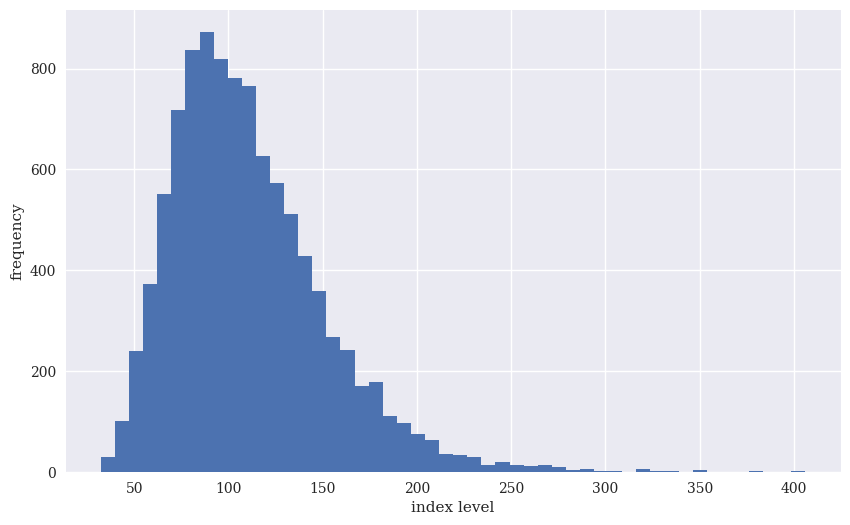

In [9]:
plt.figure( figsize = ( 10, 6 ) )
plt.hist( ST1, bins = 50 )
plt.xlabel( 'index level' )
plt.ylabel( 'frequency' )
plt.show()

# Log normal distribution


You also can use np.random.lognormal

In [10]:
ST2 = S0 * np.random.lognormal(
    (r - 0.5 * sigma ** 2) * T, sigma * np.sqrt( T ), size = I
)

# Compare Two Distribution

In [11]:
from scipy import stats

def compare_stats( rn1, rn2 ):
    stats1 = stats.describe( rn1 )
    stats2 = stats.describe( rn2 )
    print("{:14s} {:14s} {:14s}".format( 'statistic', 'data set 1', 'data set 2' ))
    print(45 * "-")
    print("{:14s} {:14.3f} {:14.3f}".format('size', stats1[0], stats2[0]))
    print("{:14s} {:14.3f} {:14.3f}".format('min', stats1[1][0], stats2[1][0]))
    print("{:14s} {:14.3f} {:14.3f}".format('max', stats1[1][1], stats2[1][1]))
    print("{:14s} {:14.3f} {:14.3f}".format('mean', stats1[2], stats2[2]))
    print("{:14s} {:14.3f} {:14.3f}".format('std', stats1[3], stats2[3]))
    print("{:14s} {:14.3f} {:14.3f}".format('skew', stats1[4], stats2[4]))
    print("{:14s} {:14.3f} {:14.3f}".format('kurtosis', stats1[5], stats2[5]))

In [12]:
compare_stats(ST1, ST2)

statistic      data set 1     data set 2    
---------------------------------------------
size                10000.000      10000.000
min                    32.327         28.230
max                   406.124        414.825
mean                  110.663        110.468
std                  1663.857       1621.720
skew                    1.197          1.167
kurtosis                2.773          2.533


# In class exercise: Future Index Time Series in Black Scholes Merton setup

Using step number $M = 100$, time step $ dt = \frac{T}{M} $, repeat above simulation process $M$ times.

$S_{ t+\Delta t } = S_t \exp( ( r - \frac{1}{2}\sigma^2 )\Delta t + \sigma \sqrt{ \Delta t } z )$

In [14]:
import math
S0 = 100
r = 0.05
sigma = 0.25
T = 2.0
I = 10000
M = 100
dt = T / M

S = np.zeros((M+1, I))
S[0] = S0
for t in range(1, M+1):
    z = np.random.standard_normal(I)
    S[t] = S[t-1] * np.exp((r - 0.5 * sigma ** 2) * dt / M + sigma * math.sqrt(dt) * z)

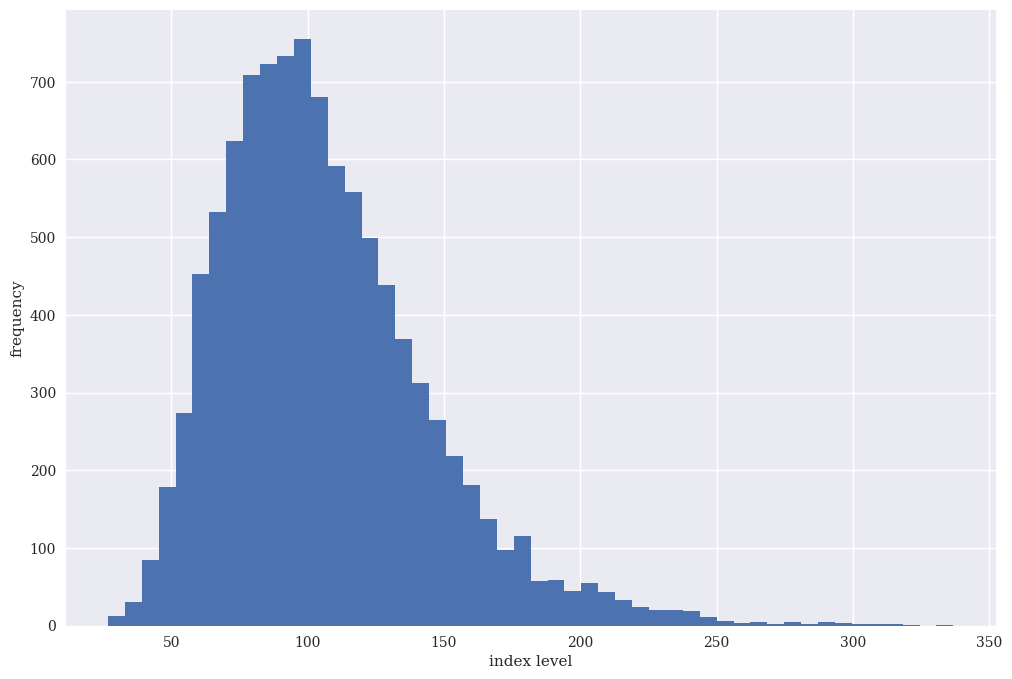

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.hist(S[100], bins=50)
ax.set_xlabel("index level")
ax.set_ylabel("frequency")
plt.show()

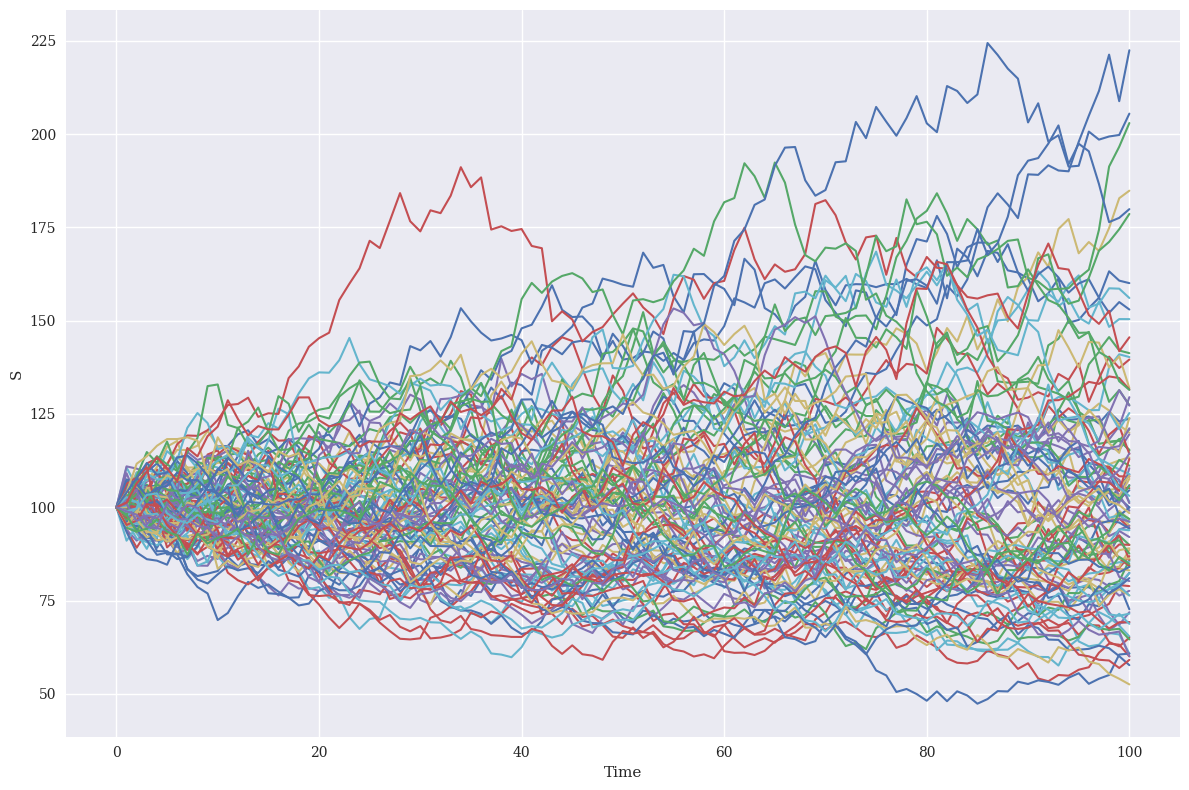

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(S[:, :100], lw=1.5)
ax.set_xlabel('Time')
ax.set_ylabel('S')
plt.tight_layout()
plt.show()

# CIR process

$ dx_t = \kappa ( \theta - x_t ) dt +\sigma \sqrt{ x_t } d Z_t $

预测利率

# In class exercise: Modified CIR process

$ \tilde{x}_t = \tilde{x}_s + \kappa ( \theta - \tilde{x}^+_s ) \Delta t + \sigma \sqrt{ \tilde{x}^+_s } \sqrt{ \Delta t } z_t  $

$x_t = \tilde{x}^+_t$

In [78]:
x0 = 0.05
kappa = 3.0
theta = 0.02
sigma = 0.1
I = 10000
M = 100
T = 2
dt = T/M

In [ ]:
def cirprocess( x0, kappa, theta, sigma, I, M, T ):
    dt = T/M
    xh = np.zeros( ( M+1, I ) )
    x = np.zeros_like( xh )
    
    xh[0] = x0
    x[0] = x0
    
    for t in range( 1, M+1 ):
        xh[t] = ( xh[ t - 1 ] + 
                kappa * ( theta - np.maximum( xh[ t - 1 ], 0 ) ) * dt +
                sigma * np.sqrt( np.maximum( xh[ t - 1 ], 0 ) ) *\
                 np.sqrt( dt ) * np.random.standard_normal( I )
                )
    x = np.maximum( xh, 0 )
    return x

# Exact Discretization

$df = \frac{4\theta\kappa}{\sigma^2}$

$nc = \frac{ 4 \kappa e^{-\kappa \Delta t} }{ \sigma^2 ( 1 - e^{-\kappa \Delta t} ) } x_s$

$x_t = \frac{ \sigma^2 ( 1 - e^{ -\kappa \Delta t } ) }{ 4\kappa } \chi'^2_d( nc )$ 

$\chi'^2_d$ can be generated by np.random.noncentral_chisquare( df, nc, size )

In [ ]:
def exact_srd( x0, kappa, theta, sigma, I, M, T ):
    """
    exact discretization scheme for the square-root diffusion
    """
    dt = T/M
    x = np.zeros( ( M+1, I ) )
    x[0] = x0
    df = 4 * theta * kappa / ( sigma ** 2 )
    for t in range( 1, M+1 ):
        c = ( sigma ** 2 * ( 1 - np.exp( -kappa * dt ) ) ) / ( 4 * kappa )
        nc = np.exp( -kappa * dt ) / c * x[t-1]
        x[t] = c * np.random.noncentral_chisquare( df, nc, I )
    return x

# Correlated Normal


How to generate two sequence of random standard normal with correlation $\rho$?

1. Generate an $n\times 2$ matrix of independent standard normals $X$

2. Get Cholesky decomposition component $L$ of correlation matrix $\Omega$. $\Omega = LL'$ ( use package np.linalg.cholesky )

3. $LX$ is the correlated normal with correlation $\rho$.

# Stochastic Volatility

$dS_t = rS_t dt + \sqrt{ v_t } S_t dZ^1_t$

$dv_t = \kappa_v ( \theta_v - v_t )dt + \sigma_v\sqrt{ v_t } dZ_t^2$

$dZ_t^1 dZ_t^2 = \rho $

In [116]:
S0 = 100
r = 0.05
v0 = 0.1
kappa = 3.0
theta = 0.25
sigma = 0.1
rho = 0.6
T = 1
M = 50
I = 10000
dt = T/M

In [ ]:
Omega = np.array( [ [1, rho], [rho, 1] ] )
cho_mat = np.linalg.cholesky( Omega )

In [ ]:
ran_num = np.random.standard_normal( ( 2, M+1, I ) )
v = np.zeros_like( ran_num[0] )
vh = np.zeros_like( ran_num[0] )
v[0] = v0
vh[0] = v0

for t in range( 1, M+1 ):
    ran = cho_mat.dot( ran_num[ :, t, : ] )
    vh[t] = ( vh[ t - 1 ] + 
            kappa * ( theta - np.maximum( vh[ t - 1 ], 0 ) ) * dt +
            sigma * np.sqrt( np.maximum( vh[ t - 1 ], 0 ) ) * np.sqrt( dt ) * ran[1]
            )    
v = np.maximum( vh, 0 )

In [ ]:
S = np.zeros_like( ran_num[0] )
S[0] = S0
for t in range( 1, M + 1 ):
    ran = cho_mat.dot( ran_num[ :, t, : ] )
    S[ t ] = S[ t - 1 ] * np.exp( ( r - 0.5 * v[t] ) * dt + 
                                np.sqrt( v[t] ) * np.sqrt( dt ) * ran[0] )